In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("wheat.data",low_memory=False)

In [3]:
df

,id,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
0,0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,kama
1,1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,kama
2,2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,kama
3,3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,kama
4,4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,kama
...,...,...,...,...,...,...,...,...,...
205,205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,canadian
206,206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,canadian
207,207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,canadian
208,208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,canadian


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           210 non-null    int64  
 1   area         210 non-null    float64
 2   perimeter    210 non-null    float64
 3   compactness  207 non-null    float64
 4   length       210 non-null    float64
 5   width        209 non-null    float64
 6   asymmetry    210 non-null    float64
 7   groove       206 non-null    float64
 8   wheat_type   210 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB


In [5]:
df.describe()

,id,area,perimeter,compactness,length,width,asymmetry,groove
count,210.000000,210.000000,210.000000,207.000000,210.000000,209.000000,210.000000,206.000000
mean,104.500000,14.847524,14.559286,0.871280,5.563918,3.281440,3.693530,5.407529
std,60.765944,2.909699,1.305959,0.023306,0.719594,0.419907,1.495112,0.532330
min,0.000000,10.590000,12.410000,0.808100,0.818900,2.630000,0.765100,3.485000
25%,52.250000,12.270000,13.450000,0.857700,5.244750,2.956000,2.600250,5.045000
50%,104.500000,14.355000,14.320000,0.873500,5.518000,3.245000,3.599000,5.226000
75%,156.750000,17.305000,15.715000,0.887650,5.979750,3.566000,4.768750,5.879000
max,209.000000,21.180000,17.250000,0.918300,6.675000,5.325000,8.456000,6.735000


In [6]:
df.isnull().sum()

id             0
area           0
perimeter      0
compactness    3
length         0
width          1
asymmetry      0
groove         4
wheat_type     0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.shape

(210, 9)

### Normalised

In [9]:
df['wheat_type'].value_counts()

canadian    76
rosa        68
kama        66
Name: wheat_type, dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

id             0
area           0
perimeter      0
compactness    0
length         0
width          0
asymmetry      0
groove         0
wheat_type     0
dtype: int64

In [12]:
df.drop(['id'],axis=1,inplace=True)

In [13]:
df

,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,kama
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,canadian
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,canadian
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,canadian
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,canadian


In [14]:
encoder = LabelEncoder()

In [15]:
df['wheat_type'] = encoder.fit_transform(df['wheat_type'])

In [16]:
df

,area,perimeter,compactness,length,width,asymmetry,groove,wheat_type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,0
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,0
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,0
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,0


In [17]:
df['wheat_type'].value_counts()

0    69
2    68
1    66
Name: wheat_type, dtype: int64

In [18]:
# Canadian = 0, Kama = 1, Rosa = 2

In [19]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]

In [20]:
X

,area,perimeter,compactness,length,width,asymmetry,groove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175
...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044


In [21]:
scaler = StandardScaler()

In [22]:
X_scaled = scaler.fit_transform(X)

In [23]:
X_scaled

array([[ 1.21366145e-01,  1.92312169e-01,  3.00501835e-03, ...,
         1.26347878e-01, -9.92457995e-01, -4.06395176e-01],
       [-9.09907835e-03, -1.43263329e-02,  4.36891576e-01, ...,
         1.81979049e-01, -1.79406080e+00, -9.43498266e-01],
       [-2.11663505e-01, -3.81683670e-01,  1.46361323e+00, ...,
         1.92575463e-01, -6.73949148e-01, -1.21001533e+00],
       ...,
       [-5.85892699e-01, -7.10774619e-01,  7.46196845e-01, ...,
        -8.55803947e-02,  3.06819663e+00, -7.40050126e-01],
       [-1.05282087e+00, -1.05517212e+00, -8.08921313e-01, ...,
        -1.13462534e+00, -7.49126348e-02, -7.64463902e-01],
       [-8.94889282e-01, -9.55679510e-01, -1.08688551e-01, ...,
        -7.69049073e-01,  1.28374749e+00, -7.25808756e-01]])

### Model Training

In [24]:
X_scaled, y.values

(array([[ 1.21366145e-01,  1.92312169e-01,  3.00501835e-03, ...,
          1.26347878e-01, -9.92457995e-01, -4.06395176e-01],
        [-9.09907835e-03, -1.43263329e-02,  4.36891576e-01, ...,
          1.81979049e-01, -1.79406080e+00, -9.43498266e-01],
        [-2.11663505e-01, -3.81683670e-01,  1.46361323e+00, ...,
          1.92575463e-01, -6.73949148e-01, -1.21001533e+00],
        ...,
        [-5.85892699e-01, -7.10774619e-01,  7.46196845e-01, ...,
         -8.55803947e-02,  3.06819663e+00, -7.40050126e-01],
        [-1.05282087e+00, -1.05517212e+00, -8.08921313e-01, ...,
         -1.13462534e+00, -7.49126348e-02, -7.64463902e-01],
        [-8.94889282e-01, -9.55679510e-01, -1.08688551e-01, ...,
         -7.69049073e-01,  1.28374749e+00, -7.25808756e-01]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
X_train.shape, X_test.shape

((162, 7), (41, 7))

In [27]:
xgb = XGBClassifier(random_state=0, n_estimators=400, objective='merror')

In [28]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='mlogloss',early_stopping_rounds=20)

[0]	validation_0-mlogloss:1.00216
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:0.91562
[2]	validation_0-mlogloss:0.84181
[3]	validation_0-mlogloss:0.781102
[4]	validation_0-mlogloss:0.728573
[5]	validation_0-mlogloss:0.683837
[6]	validation_0-mlogloss:0.64442
[7]	validation_0-mlogloss:0.611326
[8]	validation_0-mlogloss:0.582279
[9]	validation_0-mlogloss:0.551035
[10]	validation_0-mlogloss:0.528883
[11]	validation_0-mlogloss:0.504291
[12]	validation_0-mlogloss:0.482138
[13]	validation_0-mlogloss:0.469207
[14]	validation_0-mlogloss:0.451567
[15]	validation_0-mlogloss:0.436743
[16]	validation_0-mlogloss:0.423357
[17]	validation_0-mlogloss:0.416206
[18]	validation_0-mlogloss:0.403625
[19]	validation_0-mlogloss:0.395472
[20]	validation_0-mlogloss:0.385501
[21]	validation_0-mlogloss:0.381355
[22]	validation_0-mlogloss:0.375744
[23]	validation_0-mlogloss:0.368898
[24]	validation_0-mlogloss:0.366804
[25]	validation_0-mlogloss:0.364649
[26]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
y_pred = xgb.predict(X_test)

In [30]:
y_pred

array([0, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0,
       1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 1, 0, 2])

### Model Evaluation

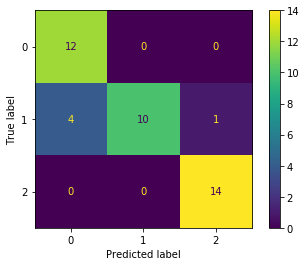

In [31]:
plot_confusion_matrix(xgb,X_test,y_test)
plt.show()

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.67      0.80        15
           2       0.93      1.00      0.97        14

    accuracy                           0.88        41
   macro avg       0.89      0.89      0.87        41
weighted avg       0.90      0.88      0.87        41

